In [1]:
!pip3 install -r requirements.txt --quiet

In [2]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 5)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [3]:
FILE_PATH = 'https://raw.githubusercontent.com/dakshbhatnagar/Datasets/refs/heads/main/customer_churn/Churn_Modelling.csv'
df = pd.read_csv(FILE_PATH)
df = df.drop(columns=['RowNumber'])
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


In [5]:
df.describe().T.apply(lambda x : round(x,2)).iloc[1:,1:]

,mean,std,min,25%,50%,75%,max
CreditScore,650.53,96.65,350.00,584.00,652.00,718.00,850.00
Age,38.92,10.49,18.00,32.00,37.00,44.00,92.00
Tenure,5.01,2.89,0.00,3.00,5.00,7.00,10.00
Balance,76485.89,62397.41,0.00,0.00,97198.54,127644.24,250898.09
NumOfProducts,1.53,0.58,1.00,1.00,1.00,2.00,4.00
HasCrCard,0.71,0.46,0.00,0.00,1.00,1.00,1.00
IsActiveMember,0.52,0.50,0.00,0.00,1.00,1.00,1.00
EstimatedSalary,100090.24,57510.49,11.58,51002.11,100193.92,149388.25,199992.48
Exited,0.20,0.40,0.00,0.00,0.00,0.00,1.00


**QUESTIONS TO DEFINITELY LOOK AT**

- Age : 18 and 92 how long are these guys associated? What's his bank balance
- Does a guy with a zero tenure have credit card, if yes, what's his credit score, bank balance and Salary and what's his age
- Are we giving out credit cards to folks with zero balance?
- Does Number of Products have any relation with the exiting?
- Active Members tend to leave more or the non active members?

In [6]:
def creditcategory(score):
  if score>= 300 and score<=499:
    return 'Poor'
  elif score>= 500 and score<=649:
    return 'Average'
  elif score>= 650 and score<=749:
    return 'Good'
  elif score>= 750 and score<=900:
    return 'Excellent'

df['CreditScoreCat'] = df['CreditScore'].apply(creditcategory)

In [7]:
conn = sqlite3.connect('churn.db')
df.to_sql('churn_data', conn, if_exists='replace', index=False)

10000

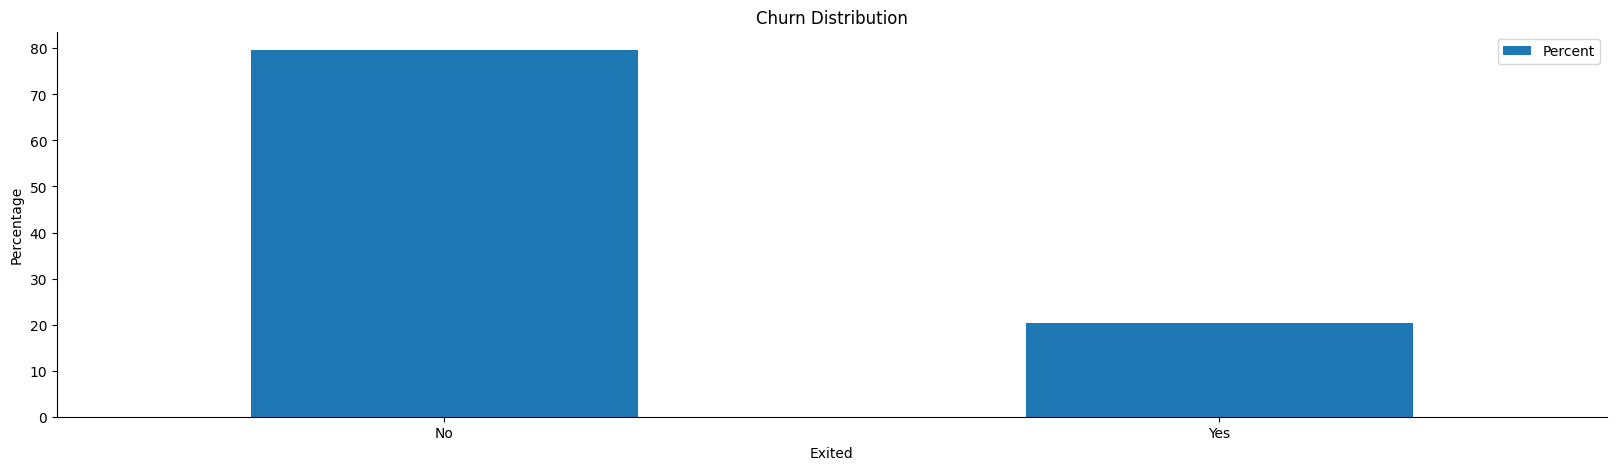

In [22]:
exited_df = (df['Exited'].value_counts()/len(df)*100).to_frame()
exited_df.plot(kind='bar')
plt.title('Churn Distribution')
plt.xticks(ticks=[0,1], labels = ['No', 'Yes'], rotation=0)
plt.ylabel('Percentage')
plt.legend(['Percent'])
plt.show()

There is definitely a class imbalance which we must keep at the back of our minds but for now we are focussing on churned folks.

In [23]:
churned = df[df['Exited']==1]
churned.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditScoreCat
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,Average
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,Average
5,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1,Average
7,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1,Poor
16,15737452,Romeo,653,Germany,Male,58,1,132602.88,1,1,0,5097.67,1,Good


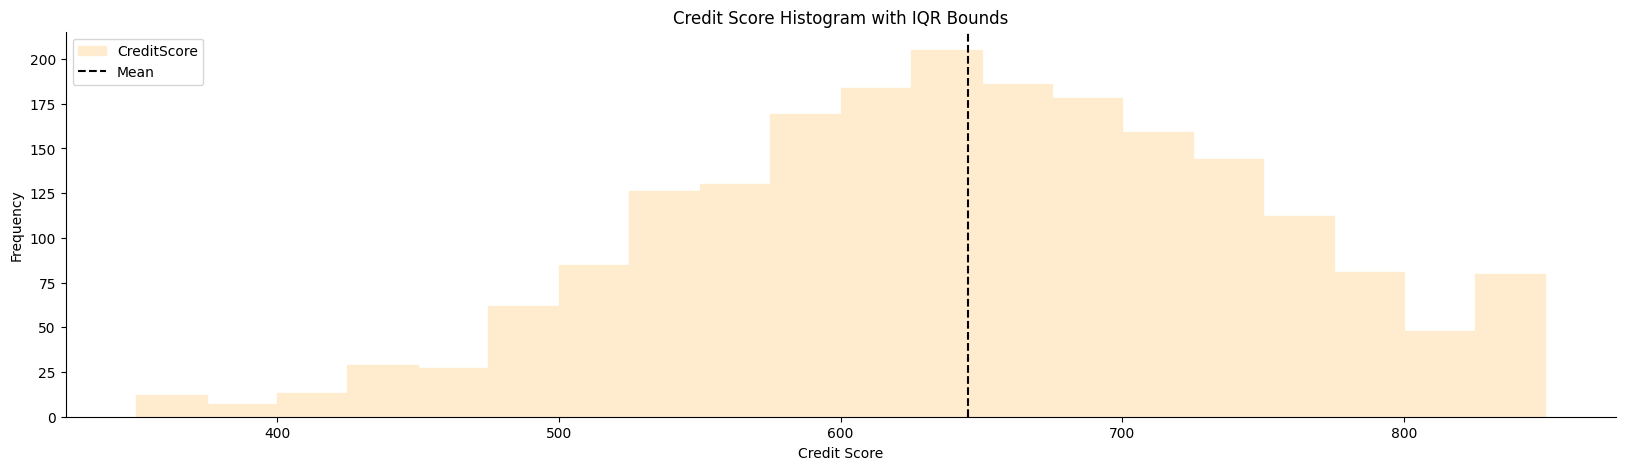

In [25]:
# Plotting the histogram for Credit Score
churned['CreditScore'].plot(kind='hist', bins=20, color='blanchedalmond', edgecolor='blanchedalmond')
Q1 = churned['CreditScore'].quantile(0.25)
Q3 = churned['CreditScore'].quantile(0.75)
mean = churned['CreditScore'].mean()
# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1
plt.axvline(mean, color='black', linestyle='--', label='Mean')
# Formatting the plot
plt.title('Credit Score Histogram with IQR Bounds')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.legend(loc='upper left')
plt.show()

Credit Score shows a left skewed histogram with a mean of 650

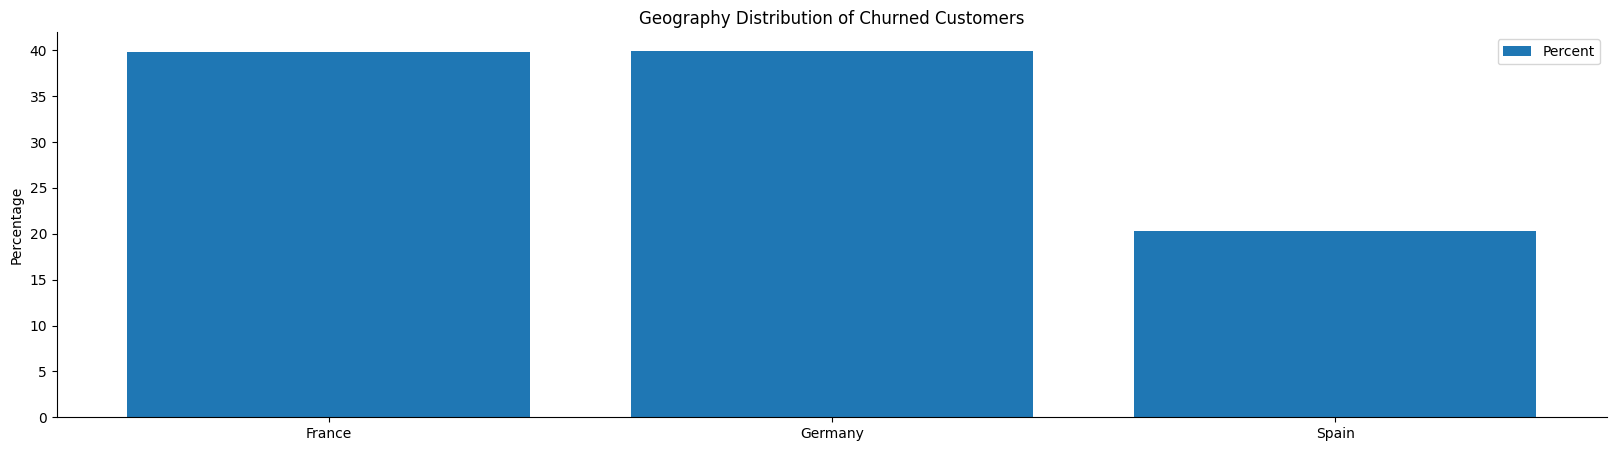

In [29]:
query = '''

select Geography, round(count(*)*1.0/(select count(*) from churn_data where Exited=1)*100,2) as Pct
      from churn_data
where Exited= 1
group by 1
'''
temp = pd.read_sql(query, conn)
plt.bar(temp['Geography'], temp['Pct'])
plt.title('Geography Distribution of Churned Customers')
plt.ylabel('Percentage')
plt.legend(['Percent'])
plt.show()

France sees the most churned folks followed by Germany and Spain

In [33]:
fr_churned = churned.query('Geography=="France" & Exited==1').reset_index(drop=True)
fr_churned.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditScoreCat
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,Average
1,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,Average
2,15794171,Lombardo,475,France,Female,45,0,134264.04,1,1,0,27822.99,1,Poor
3,15738148,Clarke,465,France,Female,51,8,122522.32,1,0,0,181297.65,1,Poor
4,15755196,Lavine,834,France,Female,49,2,131394.56,1,0,0,194365.76,1,Excellent


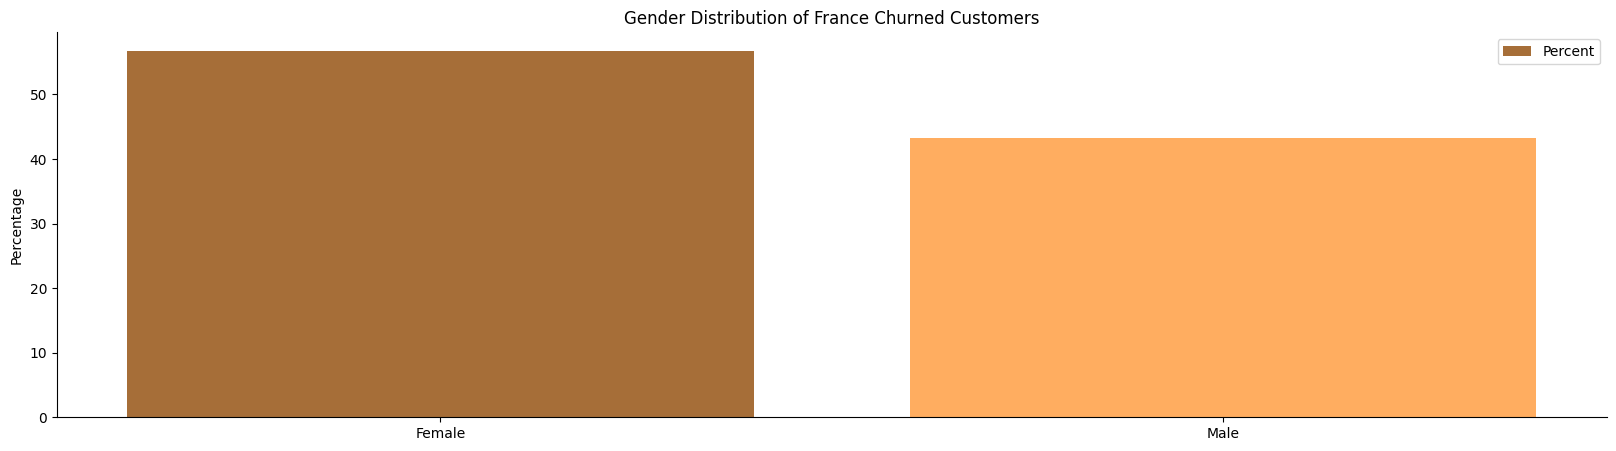

In [38]:
fr_gender = pd.DataFrame(fr_churned['Gender'].value_counts()/len(fr_churned)*100).apply(lambda x : round(x,2)).reset_index()
fr_gender = fr_gender.rename(columns={'count': 'Pct'})
colors = ['#A66E38','#FFAD60']
plt.bar(fr_gender['Gender'], fr_gender['Pct'], color=colors)
plt.title('Gender Distribution of France Churned Customers')
plt.ylabel('Percentage')
plt.legend(['Percent'])
plt.show()

French Females gets churned the most.

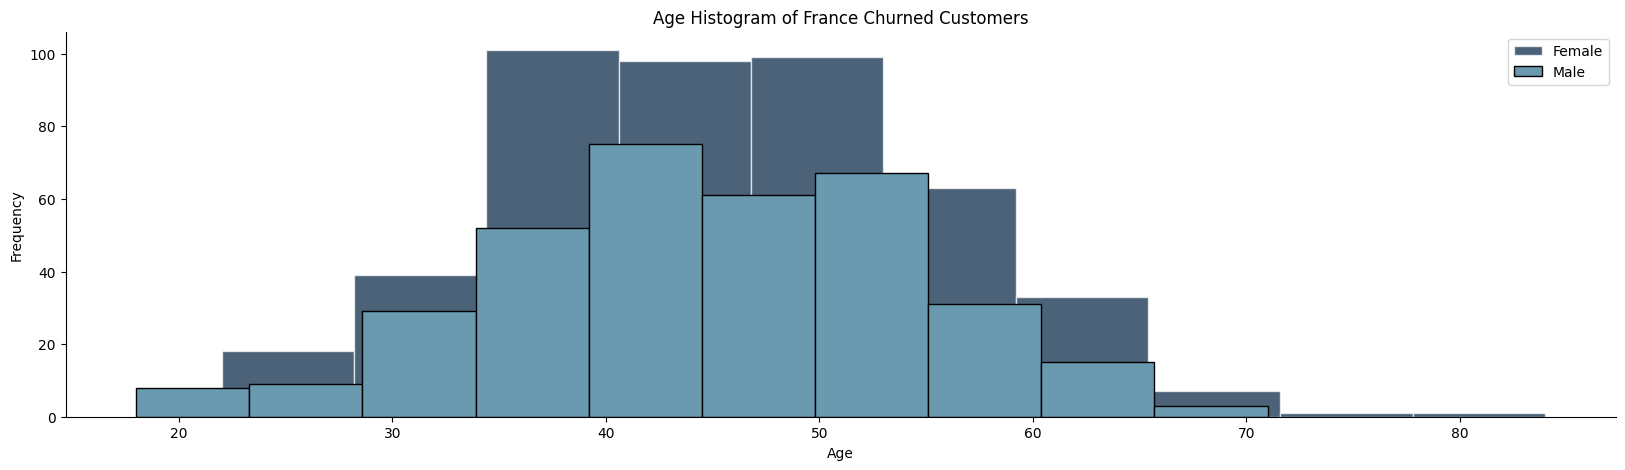

In [43]:
fr_churned.query('Gender=="Female"')['Age'].plot(kind='hist', edgecolor='white', alpha=0.7, color='#001F3F')
fr_churned.query('Gender=="Male"')['Age'].plot(kind='hist', color='#6A9AB0' , edgecolor='black')

plt.title('Age Histogram of France Churned Customers')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(['Female', 'Male'])
plt.show()

- In France, Females end up getting churned the most (56%) with an age range of 35 - 55 however in males there is only 43% churn with an age range of 40 to 45.

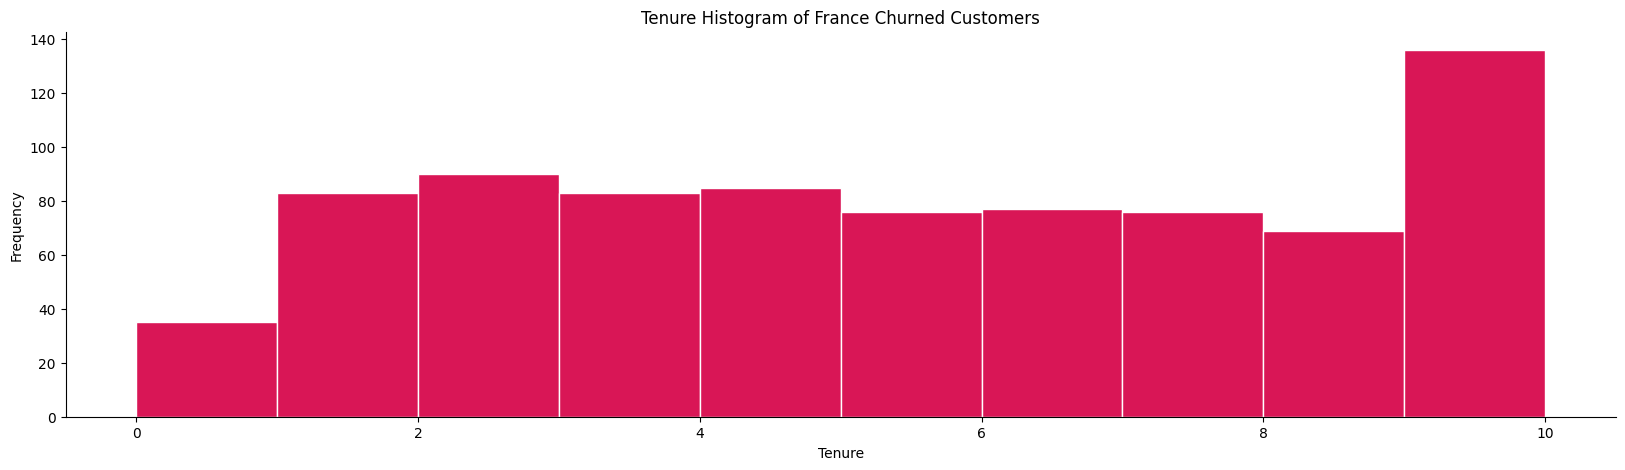

In [51]:
fr_churned['Tenure'].plot(kind='hist', color='#D91656' , edgecolor='white')

plt.title('Tenure Histogram of France Churned Customers')
plt.xlabel('Tenure')
plt.ylabel('Frequency')
plt.show()

- Folks with tenure 9-10 get churned the most in France

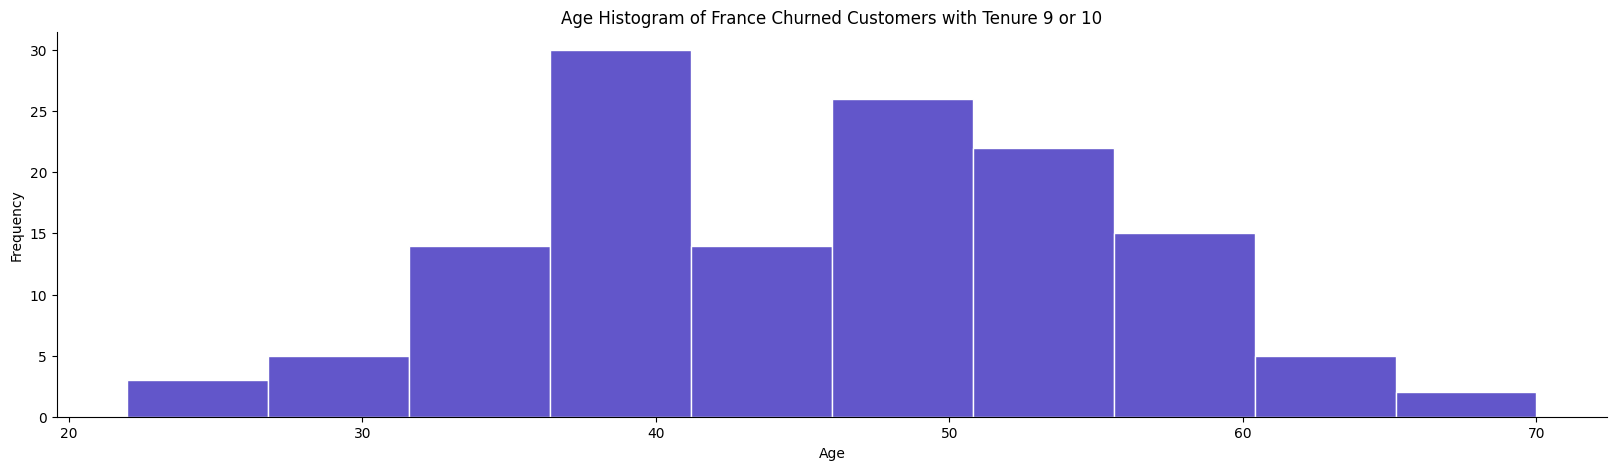

In [62]:
fr_churned.query('Tenure == 9 | Tenure ==10')['Age'].plot(kind='hist', color='#6256CA' , edgecolor='white')

plt.title('Age Histogram of France Churned Customers with Tenure 9 or 10')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Multimodal histogram of France Churned Customer's Age (Tenure 9 or 10) with peaks at 35 - 40 and 45- 50

In [60]:
fr_cr_score = pd.DataFrame(round(fr_churned.query('Tenure == 9 | Tenure ==10')['CreditScoreCat'].value_counts()/136*100,2))
fr_cr_score = fr_cr_score.rename(columns={'count': 'Pct'}).reset_index()
fr_cr_score

,CreditScoreCat,Pct
0,Average,40.44
1,Good,32.35
2,Excellent,16.91
3,Poor,10.29


- The majority of France churned customers (with Tenure of 9 or 10 years) have Average (40.44%) or Good (32.35%) credit scores, indicating higher churn risk among typically low-risk customers.

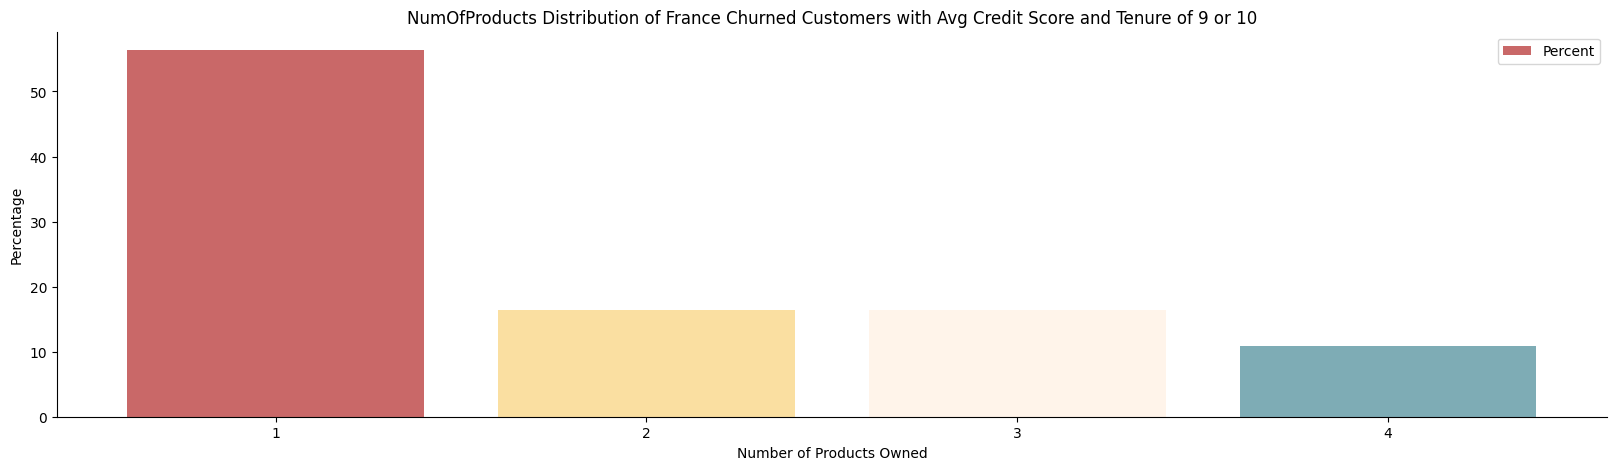

In [101]:
condition1, condition2 = (fr_churned['Tenure'].isin([9,10])), (fr_churned['CreditScoreCat'].isin(['Average', 'Good']))
fr_churned_ten_cat = fr_churned[condition1 & condition2].reset_index(drop=True)
n_rows = fr_churned_ten_cat.query('CreditScoreCat=="Average"').shape[0]
num_prod_df = (fr_churned_ten_cat.query('CreditScoreCat=="Average"')['NumOfProducts'].value_counts()/n_rows*100).to_frame().reset_index()
num_prod_df =  num_prod_df.rename(columns={'count': 'Pct'})
colors = ['#C96868','#FADFA1', '#FFF4EA', '#7EACB5']
plt.bar(num_prod_df['NumOfProducts'], num_prod_df['Pct'], color=colors)
plt.title('NumOfProducts Distribution of France Churned Customers with Avg Credit Score and Tenure of 9 or 10')
plt.ylabel('Percentage')
labels = [1, 2, 3, 4]  
plt.gca().set_xticks(labels)
plt.xlabel('Number of Products Owned')
plt.legend(['Percent'])
plt.show()

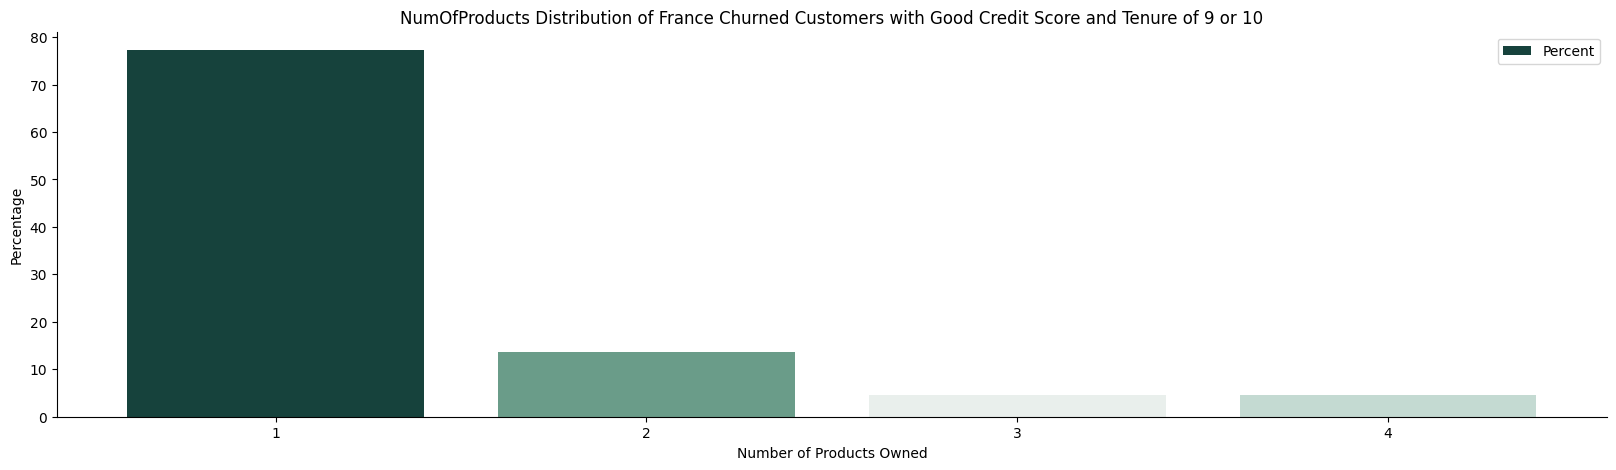

In [103]:
n_rows = fr_churned_ten_cat.query('CreditScoreCat=="Good"').shape[0]
num_prod_df = (fr_churned_ten_cat.query('CreditScoreCat=="Good"')['NumOfProducts'].value_counts()/n_rows*100).to_frame().reset_index()
num_prod_df =  num_prod_df.rename(columns={'count': 'Pct'})
colors = ['#16423C','#6A9C89', '#C4DAD2', '#E9EFEC']
plt.bar(num_prod_df['NumOfProducts'], num_prod_df['Pct'], color=colors)
plt.title('NumOfProducts Distribution of France Churned Customers with Good Credit Score and Tenure of 9 or 10')
plt.ylabel('Percentage')
plt.gca().set_xticks(labels)
plt.xlabel('Number of Products Owned')
plt.legend(['Percent'])
plt.show()

- The French Customers data indicates that a large portion of long-tenured customers (9-10) with an average or good credit score and only 1 product are more prone to churn. This could be because the product is not good enough anymore for them and they maybe need new product or new features in the same product.

In [133]:
df.select_dtypes('number').iloc[:, 1:].corr()['Exited'].to_frame()\
        .apply(lambda x : round(x, 2)).reset_index()\
        .rename(columns={'index': 'Column'})

,Column,Exited
0,CreditScore,-0.03
1,Age,0.29
2,Tenure,-0.01
3,Balance,0.12
4,NumOfProducts,-0.05
5,HasCrCard,-0.01
6,IsActiveMember,-0.16
7,EstimatedSalary,0.01
8,Exited,1.00


Age and Balance is the most related features to the Exited Columns. Rest other columns are weakly or negatively correlated.

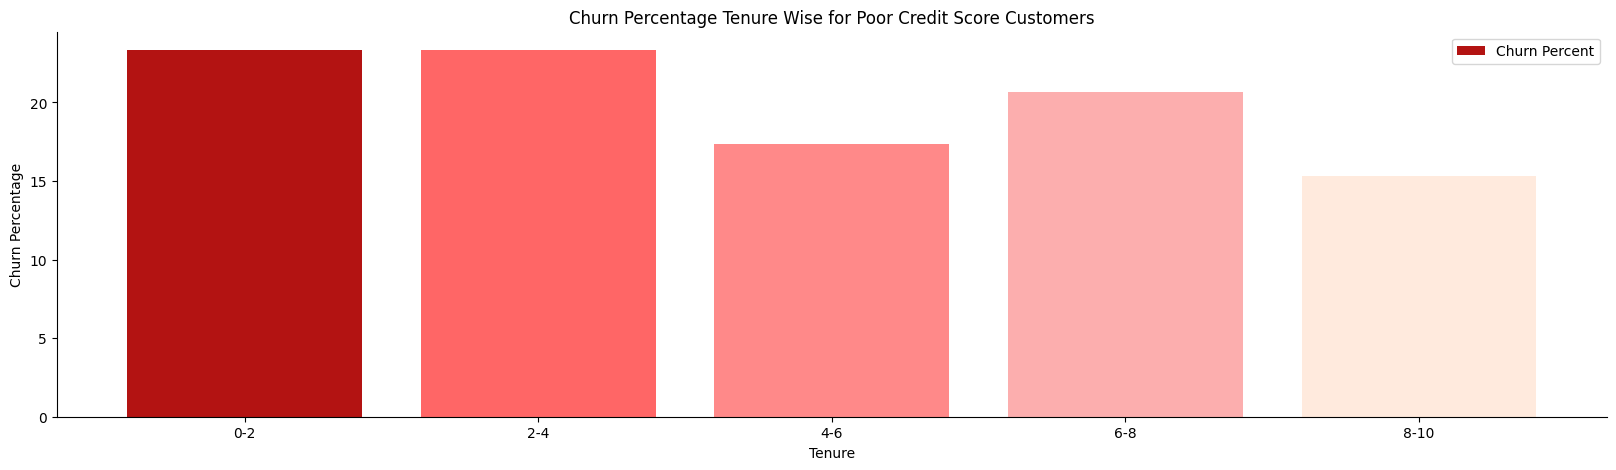

In [183]:
query = '''

with cte as (
select case when Tenure between 0 and 2 then '0-2'
         when Tenure > 2 and Tenure <= 4 then '2-4'
         when Tenure > 4 and Tenure <= 6 then '4-6'
         when Tenure > 6 and Tenure <= 8 then '6-8'
         when Tenure > 8 and Tenure <= 10 then '8-10'
        else '10+' end as Tenure_Cat, HasCrCard
 from churn_data where CreditScoreCat='Poor' and Exited=1)

 select 'Poor' as CreditScore,'Yes' as Exited, Tenure_Cat, sum(HasCrCard) as CardHolders, 
        count(*) as Count ,
        round(count(*)*100.0/ sum( count(*)) over(),2) as Pct
        from cte group by 3
'''
colors = ['#B31312','#FF6666','#FF8989', '#FCAEAE', '#FFEADD']

poor_exited = pd.read_sql(query, conn)
plt.bar(poor_exited['Tenure_Cat'], poor_exited['Pct'], color=colors)
plt.title('Churn Percentage Tenure Wise for Poor Credit Score Customers')
plt.ylabel('Churn Percentage')
plt.xlabel('Tenure')
plt.legend(['Churn Percent'])
plt.show()

- In first 4 years where customer has a poor credit score and has exited, there is a churn rate of 46% and in first 6 years, 63%

In [192]:
df.pivot_table(index='IsActiveMember', columns='Exited', aggfunc='size', fill_value=0)/len(df)*100

Exited,0,1
IsActiveMember,,
0,35.47,13.02
1,44.16,7.35


Inactive Member tend to churn out more (13%) so we may want to keep them engaged by some or the other schemes or offers or maybe showing new products.

## INSIGHTS

- 80% people don't get churned but 20% of the customers do get churned.
- Credit Score shows a left skewed histogram with a mean of 650
- France sees the most churned folks followed by Germany and Spain
- French Females gets churned the most
- Folks with tenure 9-10 get churned the most in France
- In France, Females end up getting churned the most (56%) with an age range of 35 - 55 however in males there is only 43% churn with an age range of 40 to 45.
- France Churned Customer's Age (Tenure 9 or 10) Histogram shows peaks at 35 - 40 and 45- 50
- The majority of France churned customers (with Tenure of 9 or 10 years) have Average (40.44%) or Good (32.35%) credit scores, indicating higher churn risk among typically low-risk customers.
- The French Customers data indicates that a large portion of long-tenured customers (9-10) with an average or good credit score and only 1 product are more prone to churn. This could be because the product is not good enough anymore for them and they maybe need new product or new features in the same product.
- Age and Balance are the most related features to the Exited Column. Rest other columns are weakly or negatively correlated.
- In first 4 years where customer has a poor credit score and has exited, there is a churn rate of 46% and in first 6 years, 63%
- Inactive Member tend to churn out more (13%) so we may want to keep them engaged by some or the other schemes or offers or maybe showing new products.